# don't be plastic, elastipy!

Hi there, this tutorial is actually a [jupyter notebook](https://jupyter.org/) and can be found in [examples](https://github.com/defgsus/elastipy/blob/development/examples/)/[tutorial.ipynb](https://github.com/defgsus/elastipy/blob/development/examples/tutorial.ipynb)

In [1]:
# hidden

# here we just add the parent path of this notebook to 
# the path list where python modules are searched.
# So we find elastipy even if it's not installed via setup.py
import sys
sys.path.insert(0, "..")

## exporting some objects

Without too much thinking we can just use the built-in export helper
and generate some data.

In [2]:
from elastipy import Exporter

class ShapeExporter(Exporter):
    INDEX_NAME = "elastipy-example-shapes"
    MAPPINGS = {
        "properties": {
            "shape": {"type": "keyword"},
            "color": {"type": "keyword"},
            "area": {"type": "float"},
        }
    }

The **INDEX_NAME** is obviously the name of the elasticsearch index. 
The **MAPPINGS** parameter describes the 
[elasticsearch mapping](https://www.elastic.co/guide/en/elasticsearch/reference/current/mapping.html). 
Here we say that documents will at least have these common fields, 
one of type **float** and two of type **keyword** which means they 
are strings but not full-text searchable ones. Instead they are 
efficiently indexed and aggregatable.

The data we create out of thin air.. 

In [3]:
import random

def shape_generator(count=1000):
    for i in range(count):
        yield {
            "shape": random.choice(("triangle", "square")),
            "color": random.choice(("red", "green", "blue")),
            "area": random.gauss(5, 1.3),
        }

Now create our exporter and export a couple of documents. It uses the [bulk helper tools](https://elasticsearch-py.readthedocs.io/en/7.10.0/helpers.html#bulk-helpers) internally.

In [4]:
exporter = ShapeExporter()

count, errors = exporter.export_list(shape_generator(), refresh=True)

print(count, "exported")

1000 exported


The `refresh=True` parameter will refresh the index as soon as everything is exported, so we do not have to wait for objects to appear in the elasticsearch index. 

## query oh elastipyia 

In most cases this import is enough to access all the good stuff:

In [5]:
from elastipy import Search, query

Now get some documents:

In [6]:
s = Search(index="elastipy-example-shapes")

**s** is now a search request that can be configured. Setting any search related options will always return a new instance. Here we set the maximum number of documents to respond:

In [7]:
s = s.size(3)

Next we add a [query](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl.html), more specifically a [term query](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-term-query.html).

In [8]:
s = s.term(field="color", value="green")

Our request to elasticsearch would look like this right now:

In [9]:
s.dump_body()

{
  "query": {
    "term": {
      "color": {
        "value": "green"
      }
    }
  },
  "size": 3
}


More queries can be added, which defaults to an **AND** combination:

In [10]:
s = s.range(field="area", gt=5.)
s.dump_body()

{
  "query": {
    "bool": {
      "must": [
        {
          "term": {
            "color": {
              "value": "green"
            }
          }
        },
        {
          "range": {
            "area": {
              "gt": 5.0
            }
          }
        }
      ]
    }
  },
  "size": 3
}


**OR** combinations can be archived with the [bool](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-bool-query.html) query itself or by applying the `|` operator to the query classes in `elastipy.query`:

In [11]:
s = s | (query.Term(field="color", value="red") & query.Range(field="area", gt=8.))
s.dump_body()

{
  "query": {
    "bool": {
      "should": [
        {
          "bool": {
            "must": [
              {
                "term": {
                  "color": {
                    "value": "green"
                  }
                }
              },
              {
                "range": {
                  "area": {
                    "gt": 5.0
                  }
                }
              }
            ]
          }
        },
        {
          "bool": {
            "must": [
              {
                "term": {
                  "color": {
                    "value": "red"
                  }
                }
              },
              {
                "range": {
                  "area": {
                    "gt": 8.0
                  }
                }
              }
            ]
          }
        }
      ]
    }
  },
  "size": 3
}


Better execute the search now before the body get's too complicated:

In [12]:
response = s.execute()
response.dump()

{
  "took": 2,
  "timed_out": false,
  "_shards": {
    "total": 1,
    "successful": 1,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": 169,
    "max_score": 2.1326516,
    "hits": [
      {
        "_index": "elastipy-example-shapes",
        "_type": "_doc",
        "_id": "bn6sEHcBeebHNMb6Xmm8",
        "_score": 2.1326516,
        "_source": {
          "shape": "triangle",
          "color": "green",
          "area": 5.180598032177817
        }
      },
      {
        "_index": "elastipy-example-shapes",
        "_type": "_doc",
        "_id": "dX6sEHcBeebHNMb6Xmm8",
        "_score": 2.1326516,
        "_source": {
          "shape": "square",
          "color": "green",
          "area": 6.576369444794877
        }
      },
      {
        "_index": "elastipy-example-shapes",
        "_type": "_doc",
        "_id": "eX6sEHcBeebHNMb6Xmm8",
        "_score": 2.1326516,
        "_source": {
          "shape": "square",
          "color": "green",
          "area"

The response object is a small wrapper around `dict` that has some convenience properties.

In [13]:
response.documents

[{'shape': 'triangle', 'color': 'green', 'area': 5.180598032177817},
 {'shape': 'square', 'color': 'green', 'area': 6.576369444794877},
 {'shape': 'square', 'color': 'green', 'area': 5.847317033356114}]

How many documents are there at all?

In [33]:
Search(index="elastipy-example-shapes").execute().total_hits

1000

---

The functions and properties are tried to make chainable in a way that allows for short and powerful oneliners: 

In [14]:
Search(index="elastipy-example-shapes") \
    .size(20).sort("-area").execute().documents

[{'shape': 'square', 'color': 'green', 'area': 8.79258550844049},
 {'shape': 'triangle', 'color': 'red', 'area': 8.661123759002336},
 {'shape': 'triangle', 'color': 'red', 'area': 8.565988754996523},
 {'shape': 'triangle', 'color': 'green', 'area': 8.563406508267303},
 {'shape': 'square', 'color': 'green', 'area': 8.490012394710579},
 {'shape': 'triangle', 'color': 'green', 'area': 8.291300656432396},
 {'shape': 'square', 'color': 'blue', 'area': 8.161546976474865},
 {'shape': 'square', 'color': 'blue', 'area': 8.05068744399311},
 {'shape': 'square', 'color': 'red', 'area': 7.938184774736011},
 {'shape': 'triangle', 'color': 'blue', 'area': 7.904676048185968},
 {'shape': 'square', 'color': 'blue', 'area': 7.885336389376041},
 {'shape': 'triangle', 'color': 'green', 'area': 7.875354412237241},
 {'shape': 'triangle', 'color': 'red', 'area': 7.807859334703004},
 {'shape': 'square', 'color': 'blue', 'area': 7.714386155264371},
 {'shape': 'triangle', 'color': 'red', 'area': 7.67854934890156

So this was the document response. Let's dive inside and start aggregating on fields.

## agitated aggregation

Aggregations can be created using the `agg_`, `metric_` and `pipeline_` prefixes. An aggregation is **attached** to the `Search` instance, so there is no copying like with the queries above.

In [15]:
s = Search(index="elastipy-example-shapes").size(0)

agg = s.agg_terms(field="shape")

s.dump_body()

{
  "aggregations": {
    "a0": {
      "terms": {
        "field": "shape"
      }
    }
  },
  "query": {
    "match_all": {}
  },
  "size": 0
}


As we can see, a [terms aggregation](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-terms-aggregation.html)
has been added to the search body. The names of aggregations are auto-generated, but can be explicitly stated:

In [16]:
s = Search(index="elastipy-example-shapes").size(0)

agg = s.agg_terms("shapes", field="shape")

s.dump_body()

{
  "aggregations": {
    "shapes": {
      "terms": {
        "field": "shape"
      }
    }
  },
  "query": {
    "match_all": {}
  },
  "size": 0
}


Let's look at the result from elasticsearch:

In [17]:
s.execute()
s.dump_response()

{
  "took": 1,
  "timed_out": false,
  "_shards": {
    "total": 1,
    "successful": 1,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": 1000,
    "max_score": null,
    "hits": []
  },
  "aggregations": {
    "shapes": {
      "doc_count_error_upper_bound": 0,
      "sum_other_doc_count": 0,
      "buckets": [
        {
          "key": "square",
          "doc_count": 517
        },
        {
          "key": "triangle",
          "doc_count": 483
        }
      ]
    }
  }
}


### valuable access

Because we kept the `agg` variable, we can use it's interface to access the values more conveniently:

In [18]:
agg.to_dict()

{'square': 517, 'triangle': 483}

It supports the `items()`, `keys()` and `values()` generators as known from the `dict` type:

In [19]:
for key, value in agg.items():
    print(f"{key:12} {value}")

square       517
triangle     483


It also has a `dict_rows()` generator which preseves the **names** and **keys** of the aggregation:

In [20]:
for row in agg.dict_rows():
    print(row)

{'shapes': 'square', 'shapes.doc_count': 517}
{'shapes': 'triangle', 'shapes.doc_count': 483}


The `rows()` generator flattens the `dict_rows()` into a CSV-style list:

In [21]:
for row in agg.rows():
    print(row)

['shapes', 'shapes.doc_count']
['square', 517]
['triangle', 483]


And we can print a nice table to the command-line:

In [22]:
agg.print.table()

shapes   │ shapes.doc_count                           
─────────┼────────────────────────────────────────────
square   │ 517 ███████████████████████████████████████
triangle │ 483 ████████████████████████████████████▌  


Obviously, at this point a couple of users would not understand why there is no conversion to a 
[pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) built in:

In [23]:
agg.to_pandas()  # or simply agg.df()

,shapes.doc_count
shapes,
square,517
triangle,483


The **index** and **columns** are assigned automatically. Also columns containing ISO-formatted date strings will be converted to `pandas.Timestamp`.

With `matplotlib` installed we can access the [pandas plotting interface](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html):  

<AxesSubplot:xlabel='shapes'>

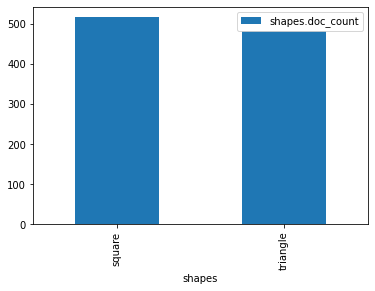

In [24]:
agg.df().plot.bar()

Now let's look into the details when **metrics** or nested **bucket** aggregations are involved.

### deeper aggregation agitation 

In [25]:
agg = Search(index="elastipy-example-shapes") \
    .agg_terms("shapes", field="shape") \
    .agg_terms("colors", field="color") \
    .metric_sum("area", field="area") \
    .metric_avg("avg-area", field="area") \
    .execute()

A few notes:
  - `agg_` methods always return the newly created aggregation, so the `colors` aggregation is nested inside the `shapes` aggregation.
  - `metric_` methods return their parent aggregation (because metrics do not allow a nested aggregation), so we can just continue to call `metric_*` and each time we add a metric to the `colors` aggregation. If you need to get access to the metric object itself add the `return_self=True` parameter.
  - The `execute` method on an aggregation does not return the response but the aggregation itself.
  
Now, what does the `to_dict` output look like?

In [26]:
agg.to_dict()

{('square', 'red'): 192,
 ('square', 'blue'): 169,
 ('square', 'green'): 156,
 ('triangle', 'green'): 166,
 ('triangle', 'blue'): 159,
 ('triangle', 'red'): 158}

It has put the **keys** that lead to each value into tuples. Without a lot of thinking we can say:

In [27]:
data = agg.to_dict()
print(f"There are {data[('triangle', 'red')]} red triangles in the database!")

There are 158 red triangles in the database!


But where are the metrics gone?

Generally, `keys()`, `values()`, `items()`, `to_dict()` and `to_matrix()` only access the values of the **current aggregation** (which is `colors` in the example). Although all the keys of the parent **bucket** aggregations that lead to the values are included.

The methods `dict_rows()`, `rows()`, `to_pandas()` and `print.table()` will access **all values** from the whole aggregation branch. In this example the branch looks like this:

- shapes
  - colors
    - area
    - avg-area

In [28]:
agg.print.table(digits=3)

shapes   │ shapes.doc_count    │ colors │ colors.doc_count    │ area                    │ avg-area            
─────────┼─────────────────────┼────────┼─────────────────────┼─────────────────────────┼─────────────────────
square   │ 517 ███████████████ │ red    │ 192 ███████████████ │ 963.596 ███████████████ │ 5.019 █████████████▊
square   │ 517 ███████████████ │ blue   │ 169 █████████████▍  │ 844.461 █████████████▎  │ 4.997 █████████████▊
square   │ 517 ███████████████ │ green  │ 156 ████████████▍   │ 782.863 ████████████▍   │ 5.018 █████████████▊
triangle │ 483 ██████████████  │ green  │ 166 █████████████   │ 825.114 ████████████▉   │ 4.971 █████████████▋
triangle │ 483 ██████████████  │ blue   │ 159 ████████████▋   │ 777.241 ████████████▎   │ 4.888 █████████████▌
triangle │ 483 ██████████████  │ red    │ 158 ████████████▌   │  805.36 ████████████▋   │ 5.097 ██████████████


Now all information is in the table. Note that the `shapes.doc_count` column contains the same value multiple times. This is because each `colors` aggregation bucket splits the `shapes` bucket into multiple results, without changing the overall count of the shapes, of course. 

Now what is this method with the awesome name `to_matrix`?

In [29]:
names, keys, matrix = agg.to_matrix()
print("names ", names)
print("keys  ", keys)
print("matrix", matrix)

names  ['shapes', 'colors']
keys   [['square', 'triangle'], ['red', 'blue', 'green']]
matrix [[192, 169, 156], [158, 159, 166]]


It produces a heatmap! At least in two dimensions. In this example we have two dimensions from the **bucket** aggregations `shapes` and `colors`. `to_matrix()` will produce a matrix with any number of dimensions, but if it's one or two, we can also convert it to a `DataFrame`:

In [30]:
agg.df_matrix()

,red,blue,green
square,192,169,156
triangle,158,159,166


And having something like [seaborn](https://seaborn.pydata.org/) installed we can easily plot it:

<AxesSubplot:>

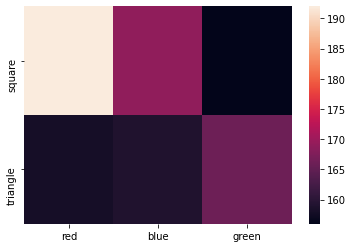

In [31]:
import seaborn as sns

sns.heatmap(agg.df_matrix())